In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from time import time
from collections import Counter
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GRU, Bidirectional,
                                     Embedding, BatchNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K

In [3]:
prices = pd.read_csv(Path('./drive/MyDrive/yf_data.csv'))
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11201118 entries, 0 to 11201117
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Date          object 
 1   open          float64
 2   high          float64
 3   low           float64
 4   close         float64
 5   volume        float64
 6   dividends     float64
 7   stock splits  float64
 8   ticker        object 
 9   filing        int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 854.6+ MB


In [4]:
filing_index = (pd.read_csv(Path('./drive/MyDrive/10K_10Q_List_With_Tickers.csv'),
                            parse_dates=['Date Filed'])
                .rename(columns=str.lower))
filing_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270645 entries, 0 to 270644
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   unnamed: 0    270645 non-null  int64         
 1   cik           270645 non-null  int64         
 2   company name  270645 non-null  object        
 3   form type     270645 non-null  object        
 4   date filed    270645 non-null  datetime64[ns]
 5   filename      270645 non-null  object        
 6   ticker        176108 non-null  object        
 7   exchange      173122 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 16.5+ MB


In [6]:
vector_path = Path('./drive/MyDrive/Vectors2/Vectors/')
files = vector_path.glob('*.npy')
filings = sorted([int(f.stem) for f in files])

In [7]:
fwd_return = {}
for filing in filings:
    date_filed = filing_index.at[filing, 'date filed']
    price_data = prices[prices.filing==filing].close.sort_index()
    
    try:
        r = (price_data
             .pct_change(periods=5)
             .shift(-5)
             #.loc[:date_filed]
             .iloc[0]
             )
    except:
        continue
    if not np.isnan(r) and -.5 < r < 1:
        fwd_return[filing] = r
len(fwd_return)

13451

In [10]:
y, X = [], []
i = 0
for filing_id, fwd_ret in fwd_return.items():
    X.append(np.load(Path('./drive/MyDrive/Vectors2/Vectors/' + str(filing_id) + '.npy')) + 2)
    y.append(fwd_ret)
    i += 1
    print(i)
y = np.array(y)
len(y), len(X)

Streaming output truncated to the last 5000 lines.
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641

(13451, 13451)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
maxlen = 20000
X_train = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [12]:
K.clear_session()
embedding_size = 100
input_dim = X_train.max() + 1
rnn = Sequential([
    Embedding(input_dim=input_dim, 
              output_dim=embedding_size, 
              input_length=maxlen,
             name='EMB'),
    BatchNormalization(name='BN1'),
    Bidirectional(GRU(32), name='BD1'),
    BatchNormalization(name='BN2'),
    Dropout(.1, name='DO1'),
    Dense(5, name='D'),
    Dense(1, activation='linear', name='OUT')
])

In [13]:
rnn.compile(loss='mse', 
            optimizer='Adam',
            metrics=[RootMeanSquaredError(name='RMSE'),
                     MeanAbsoluteError(name='MAE')])
early_stopping = EarlyStopping(monitor='val_MAE', 
                               patience=5,
                               restore_best_weights=True)
training = rnn.fit(X_train,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping],
                   verbose=1)
df = pd.DataFrame(training.history)
df.to_csv(Path('./drive/MyDrive/rnn_sec_long.csv'), index=False)

Epoch 1/100
379/379 [==============================] - 495s 1s/step - loss: 0.2116 - RMSE: 0.4600 - MAE: 0.2910 - val_loss: 0.0221 - val_RMSE: 0.1487 - val_MAE: 0.0826
Epoch 2/100
379/379 [==============================] - 488s 1s/step - loss: 0.0396 - RMSE: 0.1990 - MAE: 0.1165 - val_loss: 0.0222 - val_RMSE: 0.1491 - val_MAE: 0.0837
Epoch 3/100
379/379 [==============================] - 489s 1s/step - loss: 0.0211 - RMSE: 0.1451 - MAE: 0.0852 - val_loss: 0.0236 - val_RMSE: 0.1537 - val_MAE: 0.0895
Epoch 4/100
379/379 [==============================] - 489s 1s/step - loss: 0.0176 - RMSE: 0.1325 - MAE: 0.0780 - val_loss: 0.0211 - val_RMSE: 0.1453 - val_MAE: 0.0794
Epoch 5/100
379/379 [==============================] - 490s 1s/step - loss: 0.0163 - RMSE: 0.1276 - MAE: 0.0745 - val_loss: 0.0227 - val_RMSE: 0.1506 - val_MAE: 0.0898
Epoch 6/100
379/379 [==============================] - 488s 1s/step - loss: 0.0159 - RMSE: 0.1261 - MAE: 0.0742 - val_loss: 0.0214 - val_RMSE: 0.1463 - val_MAE:

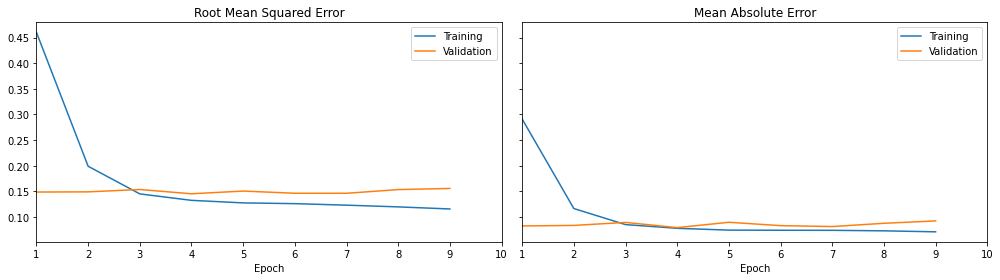

In [14]:
df.index += 1
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
plot_data = (df[['RMSE', 'val_RMSE']].rename(columns={'RMSE': 'Training', 
                                                      'val_RMSE': 'Validation'}))
plot_data.plot(ax=axes[0], title='Root Mean Squared Error')

plot_data = (df[['MAE', 'val_MAE']].rename(columns={'MAE': 'Training', 
                                                    'val_MAE': 'Validation'}))
plot_data.plot(ax=axes[1], title='Mean Absolute Error')

for i in [0, 1]:
    axes[i].set_xlim(1, 10)
    axes[i].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig(Path('./drive/MyDrive/sec_cv_performance'), dpi=300);

In [15]:
y_score = rnn.predict(X_test)

In [17]:
from scipy.stats import spearmanr
rho, p = spearmanr(y_score.squeeze(), y_test)
print(f'Information Coefficient: {rho*100:.2f} ({p:.2%})')

Information Coefficient: 0.80 (77.00%)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


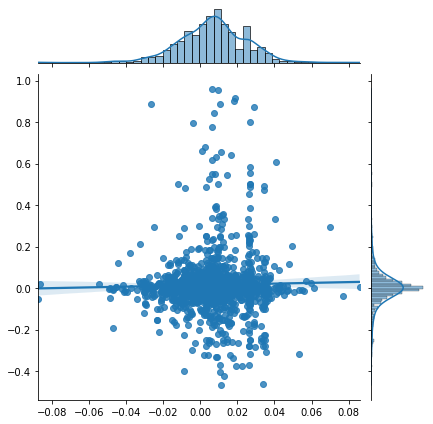

In [18]:
g = sns.jointplot(y_score.squeeze(), y_test, kind='reg');